In [2]:
!pip install transformers accelerate bitsandbytes torch datasets scikit-learn matplotlib seaborn umap-learn huggingface_hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
from datasets import load_dataset # Make sure this is imported
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login()
        print("Login successful (or token was already cached and valid).")
    else:
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}")
    print("Please ensure you have a valid Hugging Face token with access to Llama 3.")
    raise

Attempting Hugging Face login...
Hugging Face token found in cache: hf_LYkobSS... (masked)


In [4]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: Running on CPU will be very slow. Ensure GPU is enabled in Colab Runtime.")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer for '{MODEL_NAME}' loaded.")

print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None:
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))
        if hasattr(model, 'config'):
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

print("Cell 1 Setup Complete. Model and tokenizer should be loaded.")

Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct' loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
Cell 1 Setup Complete. Model and tokenizer should be loaded.


In [5]:
# Cell 2: MODIFIED for Iteration 6 - Load Sentiment Data from Hugging Face IMDb Dataset

CONCEPT_NAME = "sentiment"
N_SAMPLES_PER_CLASS_FOR_VC = 75 # Number of positive/negative samples to use for v_C

print(f"Loading '{CONCEPT_NAME}' data from IMDb dataset for v_C calculation...")

try:
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb", split='train') # Using train split

    # Separate positive and negative reviews
    # IMDb labels: 0 for negative, 1 for positive
    positive_reviews = imdb_dataset.filter(lambda example: example['label'] == 1)
    negative_reviews = imdb_dataset.filter(lambda example: example['label'] == 0)

    # Shuffle and select N samples
    # Ensure N_SAMPLES_PER_CLASS_FOR_VC is not larger than available samples
    num_pos_available = len(positive_reviews)
    num_neg_available = len(negative_reviews)

    if N_SAMPLES_PER_CLASS_FOR_VC > num_pos_available:
        print(f"Warning: Requested {N_SAMPLES_PER_CLASS_FOR_VC} positive samples, but only {num_pos_available} available. Using all available.")
        n_pos_to_select = num_pos_available
    else:
        n_pos_to_select = N_SAMPLES_PER_CLASS_FOR_VC

    if N_SAMPLES_PER_CLASS_FOR_VC > num_neg_available:
        print(f"Warning: Requested {N_SAMPLES_PER_CLASS_FOR_VC} negative samples, but only {num_neg_available} available. Using all available.")
        n_neg_to_select = num_neg_available
    else:
        n_neg_to_select = N_SAMPLES_PER_CLASS_FOR_VC

    positive_samples = positive_reviews.shuffle(seed=42).select(range(n_pos_to_select))
    negative_samples = negative_reviews.shuffle(seed=42).select(range(n_neg_to_select))

    positive_texts_for_vc = [sample['text'] for sample in positive_samples]
    negative_texts_for_vc = [sample['text'] for sample in negative_samples]

    print(f"Successfully loaded and sampled data from IMDb.")
    print(f"Number of positive examples for v_C definition: {len(positive_texts_for_vc)}")
    print(f"Number of negative examples for v_C definition: {len(negative_texts_for_vc)}")

except Exception as e:
    print(f"Error loading IMDb dataset: {e}")
    print("Falling back to manual small dataset for v_C definition.")
    positive_texts_for_vc = [
        "This is a wonderful experience and I am very happy.", "I love this product, it's absolutely fantastic!",
        "The weather is beautiful today, perfect for a walk.", "She gave a truly inspiring and uplifting speech.",
        "What a delightful surprise, it made my day!"
    ]
    negative_texts_for_vc = [
        "This is a terrible situation and I am very upset.", "I hate this product, it's absolutely awful!",
        "The weather is miserable today, dreadful for any activity.", "His comments were deeply frustrating and disheartening.",
        "What a horrible incident, it ruined everything."
    ]
    print(f"Using fallback manual dataset: {len(positive_texts_for_vc)} pos / {len(negative_texts_for_vc)} neg examples.")

# These variables will be used in Cell 3
# all_texts_for_vc = positive_texts_for_vc + negative_texts_for_vc
# labels_for_vc = [1] * len(positive_texts_for_vc) + [0] * len(negative_texts_for_vc)

Loading 'sentiment' data from IMDb dataset for v_C calculation...


Error loading IMDb dataset: Invalid pattern: '**' can only be an entire path component
Falling back to manual small dataset for v_C definition.
Using fallback manual dataset: 5 pos / 5 neg examples.


Targeting module for IMDb v_C ACTIVATION EXTRACTION: LlamaDecoderLayer (Layer -1)
Registered v_C extraction hook on last_decoder_block_output_for_imdb_vc.
Using token aggregation strategy: mean for IMDb v_C activation extraction.
Extracting positive activations from IMDb data...
  Processing 5 texts in 1 batches of size 8...
Positive IMDb activations extracted. Shape: torch.Size([5, 4096])
Extracting negative activations from IMDb data...
  Processing 5 texts in 1 batches of size 8...
Negative IMDb activations extracted. Shape: torch.Size([5, 4096])

--- Iteration 6: Training Linear Probe on IMDb Activations ---
Linear probe on IMDb activations trained. Accuracy: 100.00%
Concept vector (v_C) from IMDb PROBE calculated. Shape: torch.Size([4096])
IMDb v_C Activation extraction hook removed.

Running PCA on 10 IMDb activations used for probe...


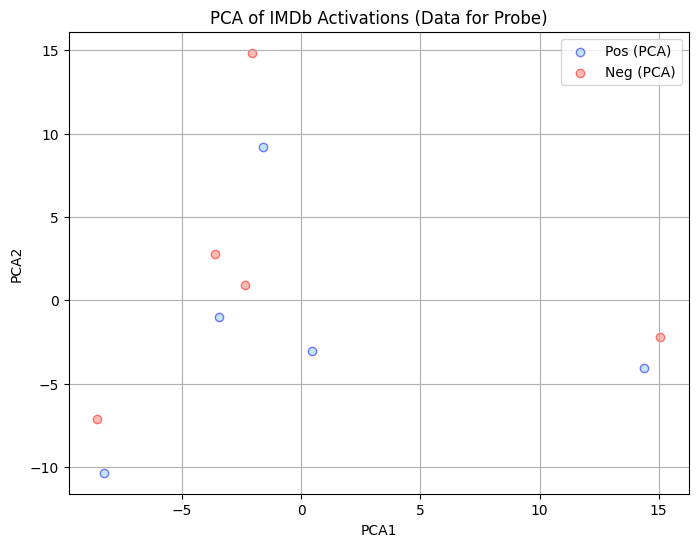

In [6]:
# Cell 3: Activation Extraction, Concept Vector ($v_C$ from Probe using IMDb data), & Optional Visualizations
# This cell now uses positive_texts_for_vc and negative_texts_for_vc from Cell 2 (populated by IMDb)
# to calculate concept_vector_sentiment_imdb.
# The v_C is extracted from the output of the FULL LAST DECODER LAYER (model.model.layers[-1]).

activations_storage = {}
def get_activation_hook(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        activations_storage[layer_name_in_storage] = (M_output[0] if isinstance(M_output, tuple) else M_output).detach()
    return hook

target_module_for_vc_extraction = None
hook_handle_vc_extraction = None
vc_extraction_hook_storage_name = "last_decoder_block_output_for_imdb_vc"

try:
    target_module_for_vc_extraction = model.model.layers[-1]
    print(f"Targeting module for IMDb v_C ACTIVATION EXTRACTION: {type(target_module_for_vc_extraction).__name__} (Layer -1)")
except Exception as e:
    print(f"Error accessing model.model.layers[-1] for v_C extraction: {e}")

if target_module_for_vc_extraction:
    if 'hook_handle_vc_extraction' in globals() and hook_handle_vc_extraction is not None:
        try: hook_handle_vc_extraction.remove(); print("Removed pre-existing v_C extraction hook.")
        except: pass
    hook_handle_vc_extraction = target_module_for_vc_extraction.register_forward_hook(get_activation_hook(vc_extraction_hook_storage_name))
    print(f"Registered v_C extraction hook on {vc_extraction_hook_storage_name}.")
else:
    print("Skipping v_C extraction hook registration as target module not found.")

def get_activations_for_texts_batch(texts_batch, storage_name, agg_token_strategy=-1, batch_size=8): # Added batch_size
    all_relevant_activations = []
    num_batches = (len(texts_batch) + batch_size - 1) // batch_size
    print(f"  Processing {len(texts_batch)} texts in {num_batches} batches of size {batch_size}...")

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(texts_batch))
        current_batch_texts = texts_batch[start_idx:end_idx]
        if not current_batch_texts: continue

        # print(f"    Processing batch {i+1}/{num_batches} (samples {start_idx}-{end_idx-1})")
        inputs = tokenizer(current_batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device) # Increased max_length for reviews
        if storage_name in activations_storage: del activations_storage[storage_name]
        with torch.no_grad(): _ = model(**inputs)
        batch_activations = activations_storage.get(storage_name)
        if batch_activations is None: raise ValueError(f"Activations not found: '{storage_name}' for batch {i+1}. Hook issue?")

        batch_activations_cpu = batch_activations.cpu()

        if agg_token_strategy == 'mean':
            all_relevant_activations.append(batch_activations_cpu.mean(dim=1))
        elif agg_token_strategy == -1:
            seq_lens = inputs.attention_mask.sum(dim=1)
            for j in range(batch_activations_cpu.shape[0]):
                last_token_idx = max(0, seq_lens[j].item()-1)
                all_relevant_activations.append(batch_activations_cpu[j, last_token_idx, :])
        else:
            all_relevant_activations.append(batch_activations_cpu[:, agg_token_strategy, :])

    if not all_relevant_activations:
        # Handle case where no activations were collected (e.g., if all texts were empty or caused issues)
        # Return an empty tensor with the expected feature dimension if possible, or raise error
        hidden_size = model.config.hidden_size
        return torch.empty((0, hidden_size), dtype=torch.float32) # Ensure dtype matches expected concatenation type

    # If activations were lists of individual tensors (e.g. last token), stack them.
    # If they were already batched (e.g. mean pooling), concatenate.
    if agg_token_strategy == -1 and isinstance(all_relevant_activations[0], torch.Tensor) and all_relevant_activations[0].ndim == 1:
        return torch.stack(all_relevant_activations)
    else: # Handles mean pooling (already batched) or if other strategies returned batched tensors
        return torch.cat(all_relevant_activations, dim=0)


# --- Initialize concept_vector_sentiment_imdb ---
concept_vector_sentiment_imdb = None # Use a new name for this iteration's v_C
positive_activations_imdb, negative_activations_imdb = None, None

if hook_handle_vc_extraction and target_module_for_vc_extraction:
    token_aggregation_strategy = 'mean' # Using last token's activations
    print(f"Using token aggregation strategy: {token_aggregation_strategy} for IMDb v_C activation extraction.")
    try:
        print("Extracting positive activations from IMDb data...")
        positive_activations_imdb = get_activations_for_texts_batch(positive_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        print(f"Positive IMDb activations extracted. Shape: {positive_activations_imdb.shape}")

        print("Extracting negative activations from IMDb data...")
        negative_activations_imdb = get_activations_for_texts_batch(negative_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        print(f"Negative IMDb activations extracted. Shape: {negative_activations_imdb.shape}")

        print("\n--- Iteration 6: Training Linear Probe on IMDb Activations ---")
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler

        all_acts_for_imdb_probe_torch = torch.cat([positive_activations_imdb, negative_activations_imdb], dim=0)
        all_acts_for_imdb_probe_numpy = all_acts_for_imdb_probe_torch.to(torch.float32).numpy()

        imdb_probe_labels = np.array([1]*len(positive_activations_imdb) + [0]*len(negative_activations_imdb))

        imdb_scaler = StandardScaler(); all_imdb_acts_scaled = imdb_scaler.fit_transform(all_acts_for_imdb_probe_numpy)

        imdb_probe_classifier = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=42)
        imdb_probe_classifier.fit(all_imdb_acts_scaled, imdb_probe_labels)
        accuracy = imdb_probe_classifier.score(all_imdb_acts_scaled, imdb_probe_labels)
        print(f"Linear probe on IMDb activations trained. Accuracy: {accuracy*100:.2f}%")

        imdb_probe_weights = imdb_probe_classifier.coef_[0]
        concept_vector_sentiment_imdb = torch.tensor(imdb_probe_weights, dtype=torch.bfloat16).to(device)
        # Optional: concept_vector_sentiment_imdb = concept_vector_sentiment_imdb / torch.norm(concept_vector_sentiment_imdb)
        print(f"Concept vector (v_C) from IMDb PROBE calculated. Shape: {concept_vector_sentiment_imdb.shape}")

    except Exception as e:
        print(f"Error during IMDb v_C activation extraction or probe training: {e}")
        concept_vector_sentiment_imdb = None
    finally:
        if hook_handle_vc_extraction: hook_handle_vc_extraction.remove(); print("IMDb v_C Activation extraction hook removed.")

    # --- Optional Visualizations of IMDb Activations used for Probe Training ---
    if positive_activations_imdb is not None and negative_activations_imdb is not None and \
       positive_activations_imdb.numel() > 0 and negative_activations_imdb.numel() > 0: # Check for non-empty tensors

        all_imdb_extracted_activations_float32 = torch.cat([positive_activations_imdb, negative_activations_imdb], dim=0).to(torch.float32)
        all_imdb_extracted_activations_numpy = all_imdb_extracted_activations_float32.numpy()
        n_positive_imdb = len(positive_activations_imdb)

        print(f"\nRunning PCA on {all_imdb_extracted_activations_numpy.shape[0]} IMDb activations used for probe...")
        pca_imdb = PCA(n_components=2); projected_pca_imdb = pca_imdb.fit_transform(all_imdb_extracted_activations_numpy)
        plt.figure(figsize=(8,6))
        plt.scatter(projected_pca_imdb[:n_positive_imdb,0], projected_pca_imdb[:n_positive_imdb,1],label="Pos (PCA)",c="skyblue",edgecolors='b', alpha=0.5)
        plt.scatter(projected_pca_imdb[n_positive_imdb:,0], projected_pca_imdb[n_positive_imdb:,1],label="Neg (PCA)",c="salmon",edgecolors='r', alpha=0.5)
        plt.xlabel("PCA1");plt.ylabel("PCA2"); plt.title("PCA of IMDb Activations (Data for Probe)"); plt.legend(); plt.grid(True); plt.show()
    else:
        print("Visualizations for IMDb activations skipped as positive/negative activations were not successfully extracted or were empty.")
else:
    print("Initial hook setup for IMDb v_C extraction failed. Concept vector cannot be calculated.")

In [7]:
# Cell 3.5: Estimate Activation Ranges for Clipping at Target STEERING Layer
# This cell remains the same as in Iteration 4.
# It estimates clipping ranges based on the output of the FULL DECODER BLOCK of Layer -3 (index 29),
# as this is where we intend to APPLY our steering intervention.
# The `final_min_clip_i6` and `final_max_clip_i6` will be defined here.

min_val_clip_iter6 = -10.0
max_val_clip_iter6 = 10.0
target_module_for_stats_iter6 = None
hook_handle_stats_iter6 = None

try:
    num_model_layers_stats_iter6 = len(model.model.layers)
    layer_for_stats_idx_from_end_iter6 = -3
    layer_for_stats_actual_idx_iter6 = num_model_layers_stats_iter6 + layer_for_stats_idx_from_end_iter6

    if not (0 <= layer_for_stats_actual_idx_iter6 < num_model_layers_stats_iter6):
        raise ValueError(f"Calculated layer_for_stats_actual_idx_iter6 {layer_for_stats_actual_idx_iter6} is out of bounds.")
    target_module_for_stats_iter6 = model.model.layers[layer_for_stats_actual_idx_iter6]
    stats_hook_storage_name_iter6 = f"layer_{layer_for_stats_actual_idx_iter6}_full_block_stats_activations"
    print(f"Targeting module for activation stats (for clipping ranges): FULL Decoder Layer {layer_for_stats_actual_idx_iter6} ({type(target_module_for_stats_iter6).__name__})")
except Exception as e:
    print(f"Error setting up target_module_for_stats_iter6: {e}")

if target_module_for_stats_iter6:
    stats_prompts_iter6 = [
        "The weather today is expected to be clear and sunny.",
        "Standard operational procedures require daily system checks.",
        "A detailed agenda was distributed before the conference began."
    ]
    activations_for_stats_list_iter6 = []

    if 'activations_storage' not in globals(): activations_storage = {}
    else:
        if stats_hook_storage_name_iter6 in activations_storage: del activations_storage[stats_hook_storage_name_iter6]

    if target_module_for_stats_iter6:
        if 'hook_handle_stats_iter6' in globals() and hook_handle_stats_iter6 is not None:
            try: hook_handle_stats_iter6.remove(); print("Removed pre-existing stats hook.")
            except: pass
        hook_handle_stats_iter6 = target_module_for_stats_iter6.register_forward_hook(get_activation_hook(stats_hook_storage_name_iter6)) # Uses get_activation_hook from Cell 3
        print(f"Registered temporary hook on FULL Decoder Layer {layer_for_stats_actual_idx_iter6} for stats gathering.")

        print(f"Gathering activations from FULL Decoder Layer {layer_for_stats_actual_idx_iter6} for clipping range estimation...")
        for text in stats_prompts_iter6:
            messages = [{"role": "user", "content": text}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
            inputs = tokenizer(prompt_string, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            if inputs.input_ids.shape[1] == 0: continue
            with torch.no_grad(): _ = model(**inputs)
            current_activations = activations_storage.get(stats_hook_storage_name_iter6)
            if current_activations is not None:
                activations_for_stats_list_iter6.append(current_activations.cpu().to(torch.float32).view(-1))
            else: print(f"Warning: No activations for '{stats_hook_storage_name_iter6}' after prompt: {text[:30]}...")

        if hook_handle_stats_iter6: hook_handle_stats_iter6.remove(); print("Temporary stats hook removed.")

    if activations_for_stats_list_iter6:
        all_stats_activations_iter6 = torch.cat(activations_for_stats_list_iter6)
        if all_stats_activations_iter6.numel() > 0 :
            min_val_clip_iter6 = -25.0 # Using fixed wider range from Iteration 4 success
            max_val_clip_iter6 = 25.0
            print(f"Using FIXED WIDER clipping range: [{min_val_clip_iter6:.4f}, {max_val_clip_iter6:.4f}] (based on Iter. 4)")
        else: print("No activation values collected for stats. Using default fixed clipping values.")
    else: print("No activations collected for stats. Using default fixed clipping values.")
else:
    print("Target module for stats not set. Using default fixed clipping values.")

final_min_clip_i6 = min_val_clip_iter6
final_max_clip_i6 = max_val_clip_iter6
print(f"FINAL Clipping range to be used for Iteration 6 steering: [{final_min_clip_i6:.4f}, {final_max_clip_i6:.4f}]")

Targeting module for activation stats (for clipping ranges): FULL Decoder Layer 29 (LlamaDecoderLayer)
Registered temporary hook on FULL Decoder Layer 29 for stats gathering.
Gathering activations from FULL Decoder Layer 29 for clipping range estimation...
Temporary stats hook removed.
Using FIXED WIDER clipping range: [-25.0000, 25.0000] (based on Iter. 4)
FINAL Clipping range to be used for Iteration 6 steering: [-25.0000, 25.0000]


In [8]:
# Cell 4: Evaluation Setup & Test Prompts
# This cell remains identical to the version used in Iteration 4.
# It defines test_prompts_base, score_concept_control, and calculate_perplexity.

test_prompts_base = ["The report covered several key areas of the project", "During the weekly meeting, the team discussed", "The system update is scheduled to deploy", "Feedback from the initial user testing indicated", "Further analysis of the data revealed that"]
sentiment_classifier_pipe, ppl_model, ppl_tokenizer = None, None, None
try:
    sentiment_classifier_pipe = hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1); print("Sentiment classifier loaded.")
except Exception as e: print(f"Error loading sentiment classifier: {e}")

def score_concept_control(generated_texts, target_sentiment_label="POSITIVE", target_score_threshold=0.7):
    if not generated_texts or sentiment_classifier_pipe is None: return 0.0
    valid_texts = [t for t in generated_texts if isinstance(t, str) and t.strip()];
    if not valid_texts: return 0.0
    sentiments = sentiment_classifier_pipe(valid_texts)
    controlled_count = sum(1 for r in sentiments if r['label'].upper() == target_sentiment_label.upper() and r['score'] > target_score_threshold)
    return (controlled_count / len(valid_texts)) * 100 if valid_texts else 0.0

try:
    ppl_model_name = "gpt2"; print(f"Loading PPL model: {ppl_model_name}...")
    ppl_tokenizer = AutoTokenizer.from_pretrained(ppl_model_name)
    ppl_model = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
    if ppl_tokenizer.pad_token is None: ppl_tokenizer.pad_token = ppl_tokenizer.eos_token
    print(f"PPL model '{ppl_model_name}' loaded.")
except Exception as e: print(f"Error loading PPL model: {e}")

def calculate_perplexity(texts_list):
    if not texts_list or ppl_model is None: return float('inf')
    total_nll, total_tokens, valid_texts_count = 0, 0, 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        max_len = ppl_tokenizer.model_max_length if ppl_tokenizer.model_max_length < 100000 else 1024
        encodings = ppl_tokenizer(text_item,return_tensors="pt",padding=True,truncation=True,max_length=max_len).to(device)
        if encodings.input_ids.numel() == 0: continue
        valid_texts_count +=1
        with torch.no_grad(): outputs = ppl_model(encodings.input_ids, labels=encodings.input_ids)
        total_nll += outputs.loss.item() * encodings.input_ids.size(1); total_tokens += encodings.input_ids.size(1)
    if total_tokens == 0: return float('inf')
    return torch.exp(torch.tensor(total_nll / total_tokens)).item()
print("Evaluation functions and test_prompts_base defined for Iteration 6.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Sentiment classifier loaded.
Loading PPL model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PPL model 'gpt2' loaded.
Evaluation functions and test_prompts_base defined for Iteration 6.


In [9]:
# Cell 5: MODIFIED for Iteration 6 - Steering Experiment with IMDb-Derived $v_C$

# Check if the IMDb-derived concept vector from Cell 3 is available
if 'concept_vector_sentiment_imdb' not in globals() or concept_vector_sentiment_imdb is None:
    print("ERROR: `concept_vector_sentiment_imdb` is not defined from Cell 3. Cannot run Iteration 6.")
elif 'final_min_clip_i6' not in globals() or 'final_max_clip_i6' not in globals():
    print("ERROR: `final_min_clip_i6` or `final_max_clip_i6` not defined from Cell 3.5. Cannot run Iteration 6.")
else:
    print(f"Proceeding with Iteration 6 using IMDb-derived $v_C$. Shape: {concept_vector_sentiment_imdb.shape}.")
    print(f"Using Clipping range from Cell 3.5: [{final_min_clip_i6:.4f}, {final_max_clip_i6:.4f}]")

    # --- Iteration 6 Configuration ---
    # Steer at champion layer: Layer -3 (index 29)
    champion_actual_layer_index_i6 = -1 # Placeholder
    try:
        num_model_layers_i6 = len(model.model.layers)
        champion_layer_idx_from_end_i6 = -3
        champion_actual_layer_index_i6 = num_model_layers_i6 + champion_layer_idx_from_end_i6

        if not (0 <= champion_actual_layer_index_i6 < num_model_layers_i6):
            raise ValueError(f"Champion steering layer index {champion_actual_layer_index_i6} out of bounds.")
        champion_steering_module_i6 = model.model.layers[champion_actual_layer_index_i6]
        champion_steering_module_i6.layer_idx = champion_actual_layer_index_i6
        print(f"Champion STEERING module for Iteration 6: FULL Decoder Layer {champion_actual_layer_index_i6} ({type(champion_steering_module_i6).__name__})")
    except Exception as e:
        print(f"Error setting champion_steering_module for Iteration 6: {e}. Cannot proceed."); champion_steering_module_i6 = None

    # Champion alphas from previous bests
    alpha_positive_champion_i6 = 0.5
    alpha_negative_champion_i6 = -1.0

    max_new_gen_tokens_i6 = 40
    tokenizer_input_max_len_i6 = 512
    iteration_results_i6 = {}

    # --- Steering Hook Function (can reuse from Iteration 4, ensures clipping) ---
    def steering_hook_fn_i6(concept_vector_to_add, alpha_value,
                            p_clip_min, p_clip_max, steer_token_idx=-1):
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))

            modified_output_tensor = torch.clamp(modified_output_tensor, p_clip_min, p_clip_max)

            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook

    # --- No-Clip Steering Hook Function (for negative steering) ---
    def no_clip_steering_hook_fn_i6(concept_vector_to_add, alpha_value, steer_token_idx=-1):
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))
            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook


    # --- Generate and Evaluate Function (adapted for Iteration 6 logging) ---
    def generate_and_evaluate_i6(current_run_name, prompts_base_list, steering_module_for_hook,
                                 apply_steering=False, concept_vec=None, # This will be concept_vector_sentiment_imdb
                                 alpha_val=0, target_sentiment_for_ccs=None,
                                 use_clipping=False, p_min_clip_val=-25.0, p_max_clip_val=25.0):
        generated_texts_for_eval = []
        hook_handle_steering_i6 = None

        steering_status_msg = "No steering / Baseline"
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            clip_status = "ON" if use_clipping else "OFF"
            steering_status_msg = f"Steering IMDb_vC @ L{getattr(steering_module_for_hook, 'layer_idx', 'N/A')}, Alpha:{alpha_val:.2f}, Clip:{clip_status}"

            if use_clipping:
                current_hook_fn = steering_hook_fn_i6(concept_vec, alpha_val, p_min_clip_val, p_max_clip_val, steer_token_idx=-1)
            else: # No clipping for negative steering
                current_hook_fn = no_clip_steering_hook_fn_i6(concept_vec, alpha_val, steer_token_idx=-1)
            hook_handle_steering_i6 = steering_module_for_hook.register_forward_hook(current_hook_fn)

        print(f"\nGenerating texts for '{current_run_name}' ({steering_status_msg})...")

        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len_i6, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens_i6,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i6: hook_handle_steering_i6.remove()

        current_ppl = calculate_perplexity(generated_texts_for_eval)
        current_ccs = 0.0
        if target_sentiment_for_ccs and generated_texts_for_eval:
            current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

        iteration_results_i6[current_run_name] = {"ppl": current_ppl, "ccs": current_ccs if target_sentiment_for_ccs else "N/A",
                                                  "outputs": generated_texts_for_eval, "alpha": alpha_val,
                                                  "steering_layer_idx": getattr(steering_module_for_hook, 'layer_idx', 'N/A' if apply_steering else 'Baseline'),
                                                  "clipping": "ON" if (apply_steering and use_clipping) else "OFF",
                                                  "vc_source": "IMDb_Probe" if apply_steering else "N/A"}
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
        if target_sentiment_for_ccs: print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
        else: print("")
        return generated_texts_for_eval

    # --- Main Execution for Iteration 6 ---
    if champion_steering_module_i6 and ('concept_vector_sentiment_imdb' in globals() and concept_vector_sentiment_imdb is not None):
        print("\n--- Iteration 6: Evaluating Steering with IMDb-Derived $v_C$ ---")
        print(f"Using IMDb-Derived $v_C$. Applying steering at FULL Decoder Layer: {champion_actual_layer_index_i6}")
        print(f"Using Clipping Range for positive steering: [{final_min_clip_i6:.4f}, {final_max_clip_i6:.4f}]")

        # 1. Baseline (Run once if needed, or use previous Iteration baseline PPL)
        # generate_and_evaluate_i6("baseline_i6", test_prompts_base, champion_steering_module_i6, apply_steering=False)
        print(f"Reference Baseline PPL (from previous best): ~65.07 (No steering)")


        # 2. Positive Steering WITH IMDb_vC & Clipping ON
        generate_and_evaluate_i6(
            current_run_name=f"IMDb_vC_L{champion_actual_layer_index_i6}_clip_ON_pos_alpha_{alpha_positive_champion_i6:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i6,
            apply_steering=True,
            concept_vec=concept_vector_sentiment_imdb, # Use IMDb-derived v_C
            alpha_val=alpha_positive_champion_i6,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=True,
            p_min_clip_val=final_min_clip_i6,
            p_max_clip_val=final_max_clip_i6
        )

        # 3. Negative Steering WITH IMDb_vC & Clipping OFF
        generate_and_evaluate_i6(
            current_run_name=f"IMDb_vC_L{champion_actual_layer_index_i6}_clip_OFF_neg_alpha_{alpha_negative_champion_i6:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i6,
            apply_steering=True,
            concept_vec=concept_vector_sentiment_imdb, # Use IMDb-derived v_C
            alpha_val=alpha_negative_champion_i6,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=False # Clipping OFF for negative
        )

        print("\n--- Iteration 6 Evaluation Complete ---")
        print("\nSummary of Iteration 6 Results (IMDb-Derived $v_C$):")
        for run_name, metrics in iteration_results_i6.items():
            print(f"  Run: {run_name}, SteeringLayer: {metrics.get('steering_layer_idx', 'N/A')}, Alpha: {metrics.get('alpha', 'N/A'):.1f}, Clip: {metrics.get('clipping', 'N/A')}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")

        print("\nRecall CHAMPION Iteration 4 (Positive) & Iteration 3 (Negative) results (Probe $v_C$ from 5+5 examples):")
        print("  CHAMPION POSITIVE (Iter 4): (L29, alpha 0.5, Clip ON [-25,25]): CCS 100.0%, PPL 45.15")
        print("  CHAMPION NEGATIVE (Iter 3): (L29, alpha -1.0, Clip OFF): CCS 80.0%, PPL 35.23")
    else:
        print("Skipping Iteration 6 due to missing prerequisites (champion_steering_module, concept_vector_sentiment_imdb, or clip values).")

Proceeding with Iteration 6 using IMDb-derived $v_C$. Shape: torch.Size([4096]).
Using Clipping range from Cell 3.5: [-25.0000, 25.0000]
Champion STEERING module for Iteration 6: FULL Decoder Layer 29 (LlamaDecoderLayer)

--- Iteration 6: Evaluating Steering with IMDb-Derived $v_C$ ---
Using IMDb-Derived $v_C$. Applying steering at FULL Decoder Layer: 29
Using Clipping Range for positive steering: [-25.0000, 25.0000]
Reference Baseline PPL (from previous best): ~65.07 (No steering)

Generating texts for 'IMDb_vC_L29_clip_ON_pos_alpha_0.5' (Steering IMDb_vC @ L29, Alpha:0.50, Clip:ON)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'It sounds like you're summarizing a report about a project. Would you like to continue summarizing t...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'It sounds like the team had a productive meeting and discussed some important topics. Can you please...'
  Prompt: 'The system update is sched

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Prompt: 'Further analysis of the data revealed that...' -> Completion: 'It sounds like you've gained some valuable insights from analyzing the data! I'd love to hear more a...'
Results for 'IMDb_vC_L29_clip_ON_pos_alpha_0.5': PPL: 35.79, CCS (POSITIVE): 60.00%

Generating texts for 'IMDb_vC_L29_clip_OFF_neg_alpha_-1.0' (Steering IMDb_vC @ L29, Alpha:-1.00, Clip:OFF)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'Please go ahead and share the report's summary. I'll help you break it down and provide any addition...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'I'd be happy to help! What was the topic of the weekly meeting, and what was the general feeling tha...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'The system update is scheduled to deploy, and in summary, the general feeling was that it's about to...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: '